In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [37]:
datafile = h5py.File('/data/user/dfuchsgruber/train.hd5')

In [38]:
class_names = {
    0 : 'skimming',
    1 : 'cascade',
    2 : 'throughgoing track',
    3 : 'starting track',
    4 : 'class4'
}

In [39]:
def get_event_offsets(datafile):
    number_vertices = np.array(datafile['NumberVertices'])
    return number_vertices.cumsum() - number_vertices

In [40]:
offsets = get_event_offsets(datafile)
offsets

array([        0,       110,       249, ..., 592559028, 592559075,
       592559119])

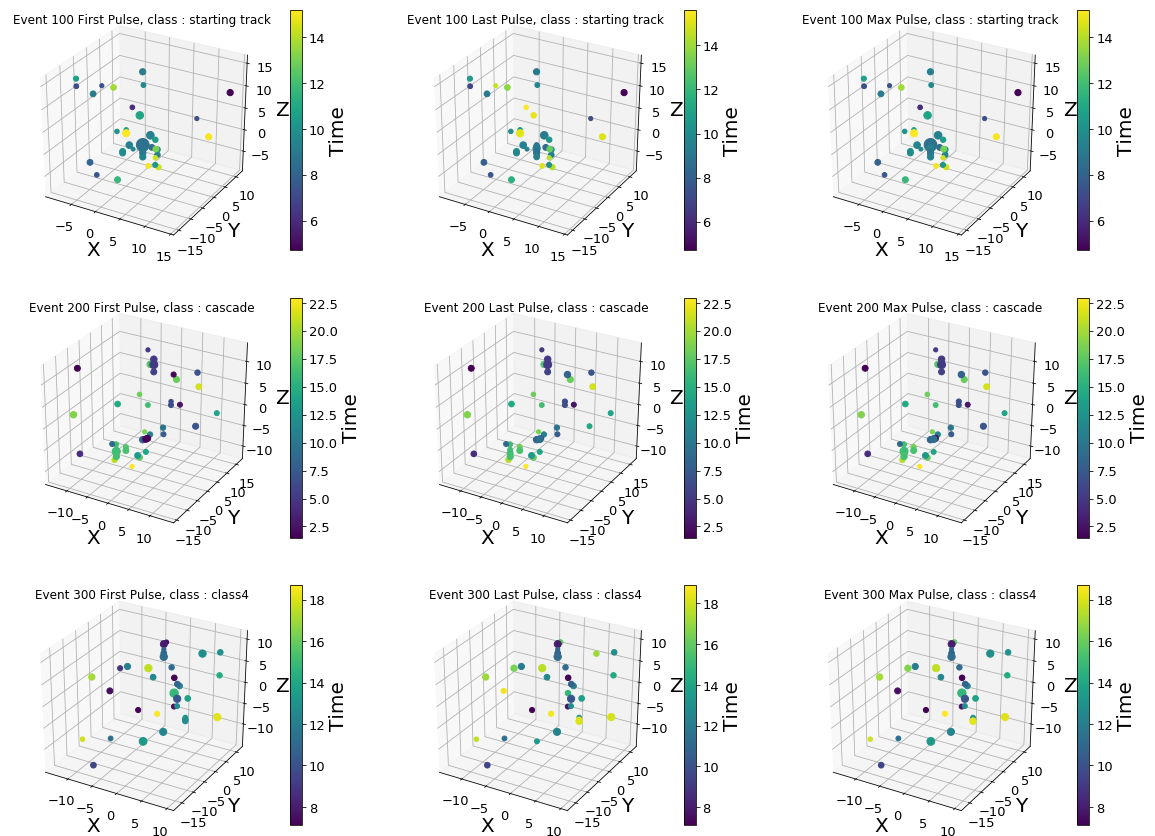

In [41]:
def visualize(datafile, offsets, event_idxs):
    num_rows = len(event_idxs)
    fig = plt.figure(figsize=(20, 5 * num_rows))
    for row, event_idx in enumerate(event_idxs):
    
        #print('Class', class_names[datafile['classification'][event_idx]])
        start_idx, end_idx = offsets[[event_idx, event_idx + 1]]
        #print('From', start_idx, 'to', end_idx)
        x = datafile['VertexX'][start_idx : end_idx]
        y = datafile['VertexY'][start_idx : end_idx]
        z = datafile['VertexZ'][start_idx : end_idx]



        for column, pulse in enumerate(('First', 'Last', 'Max')):
            feature_color = 'Time' + pulse + 'Pulse'
            feature_size = 'Charge' + pulse + 'Pulse'
            colors = datafile[feature_color][start_idx : end_idx]
            sizes = datafile[feature_size][start_idx : end_idx]
            ax = fig.add_subplot(num_rows, 3, 3 * (row) + column + 1, projection='3d')
            ax.set_title('Event ' + str(event_idx) + ' ' + pulse + ' Pulse, class : ' + 
                            class_names[datafile['classification'][event_idx]])
            p = ax.scatter(x, y, zs=z, c=colors, s=30 * sizes, depthshade=False, label='Time (ms)')
            cbar = fig.colorbar(p, label='Time')
            cbar.ax.tick_params(labelsize=13)
            cbar.set_label('Time', fontsize=20)
            plt.xlabel('X', fontsize=20)
            plt.xticks(fontsize=13)
            plt.ylabel('Y', fontsize=20)
            plt.yticks(fontsize=13)
            ax.set_zlabel('Z', fontsize=20)
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(13)


visualize(datafile, offsets, [100, 200, 300])

In [29]:
model_idx = 'hd5-5122552443'
config_path = f'training/{model_idx}/config.json'
with open('default_settings.json') as f:
        config = json.load(f)
with open(config_path) as f:
    util.dict_update(config, json.load(f))

data_train, data_val, data_test = util.dataset_from_config(config, filter_non_train=False, close_file=False)
model = util.model_from_config(config)

/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:475: RuntimeWarning: invalid value encountered in less
  filter[idx_removed] = False
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:481: RuntimeWarning: invalid value encountered in greater
  filter[idx_removed] = False


After Track Length filter 962503 / 1762366 events remain.
After Cascade Energy filter 790833 / 1762366 events remain.
Reduced dataset to 118702 samples per class (237404 / 1762366)
(1762366,) (237404,)
(237404,)
(220296,) (220296,)
(220296,)
(220295,) (220295,)
(220295,)


20 20 2000


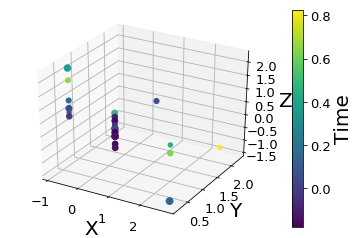

In [67]:
idx = 2000
X, C, y, w = data_train[idx]
idx = data_test._idxs[idx]
X_df = pd.DataFrame(X)
X_df.columns = data_train.feature_names

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(C[:,0], C[:,1], zs=C[:,2], c=X_df['TimeMaxPulse'], s=30 * X_df['ChargeMaxPulse'], 
               depthshade=False, label='Time (ms)')
cbar = fig.colorbar(p, label=f'Time')
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Time', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.xticks(fontsize=13)
plt.ylabel('Y', fontsize=20)
plt.yticks(fontsize=13)
ax.set_zlabel('Z', fontsize=20)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(13)
fig.savefig('../poster/event.svg')


In [69]:
from sklearn.metrics import pairwise_distances
from scipy.special import softmax

In [70]:
idx_sorted = np.argsort(X_df['TimeFirstPulse'])

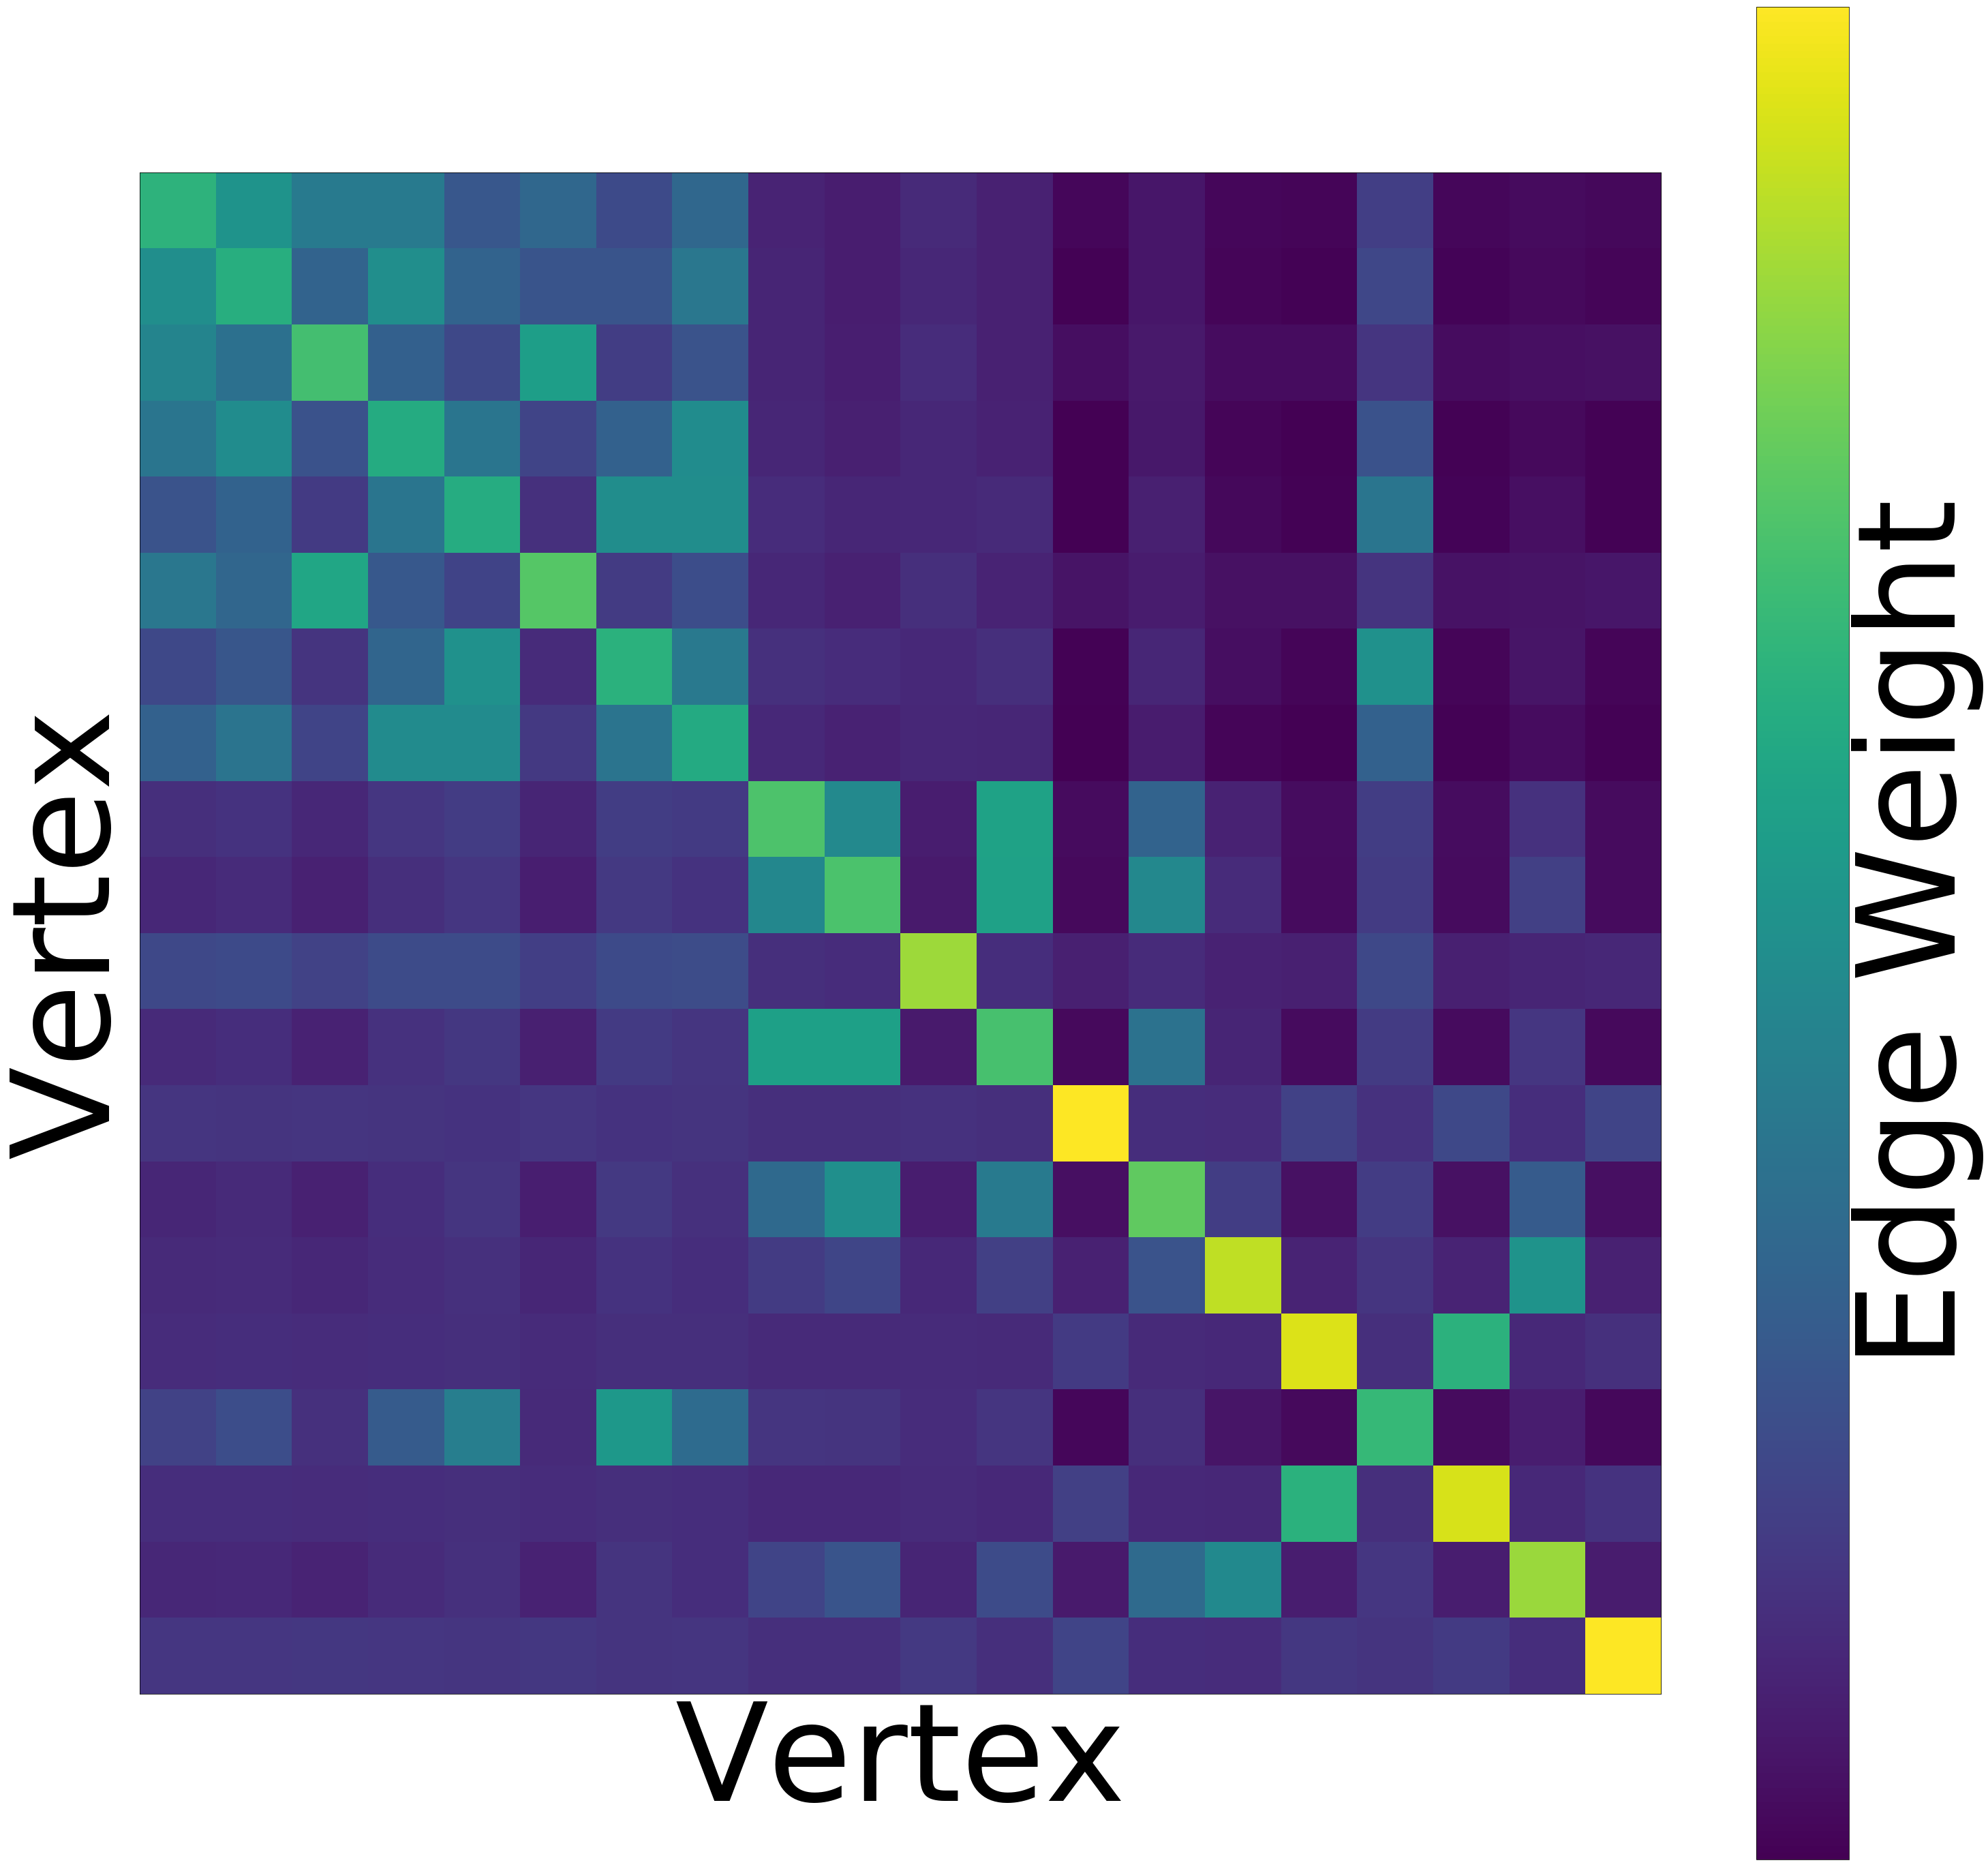

In [71]:
A = np.exp(-pairwise_distances(C))[idx_sorted][:, idx_sorted]
A = softmax(A, axis=1)
fig = plt.figure(figsize=(50, 50))
p = plt.imshow(A, interpolation=None)
cbar = plt.colorbar(p, label='Edge Weight')
plt.xticks([])
plt.yticks([])
plt.xlabel('Vertex', fontsize=200)
plt.ylabel('Vertex', fontsize=200)
cbar.set_label('Edge Weight', fontsize=200)
cbar.set_ticks([])
plt.savefig('../poster/adjacency.svg')

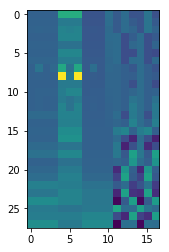

In [61]:
plt.imshow(X[idx_sorted])

# Check distribution of possible attributes, all should be uniform

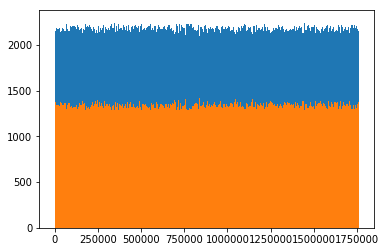

In [70]:
idxs_track = np.where(targets == 1)[0]
idxs_non_track = np.where(targets == 0)[0]
idxs_track.shape, idxs_non_track.shape
_ = plt.hist(idxs_track, bins=500)
_ = plt.hist(idxs_non_track, bins=500)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


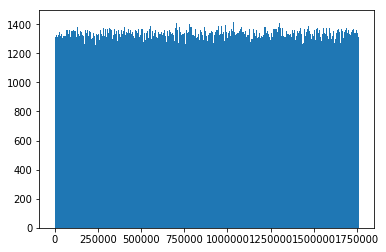

In [71]:
track_length = np.array(f['TrackLength'])
has_track_length = ~np.isnan(track_length)
idx_removed_track_length = np.where(np.logical_and((track_length < 70), has_track_length))[0]
_ = plt.hist(idx_removed_track_length, bins=500)

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


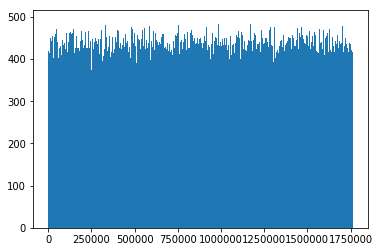

In [72]:
cascade_energy = np.array(f['CascadeEnergy'])
idx_removed_cascade = np.where(np.logical_and((cascade_energy > 10), has_track_length))
_ = plt.hist(idx_removed_cascade, bins=500)

In [73]:
filter = np.ones(has_track.shape[0], dtype=np.bool)
filter[idx_removed_cascade] = False
filter[idx_removed_track_length] = False
filtered_idx = np.where(filter)[0]

((284650,), (672131,))

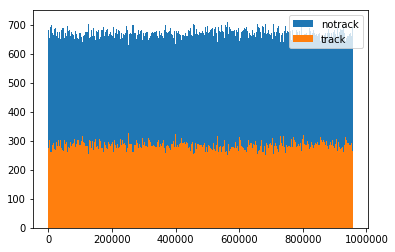

In [74]:
targets_filtered = targets[filtered_idx]
idxs_track_filtered = np.where(targets_filtered == 1)[0]
idxs_non_track_filtered = np.where(targets_filtered == 0)[0]
_ = plt.hist(idxs_non_track_filtered, bins=1000, label='notrack')
_ = plt.hist(idxs_track_filtered, bins=1000, label='track')
plt.legend()
idxs_track_filtered.shape, idxs_non_track_filtered.shape

((284650,), (284650,))

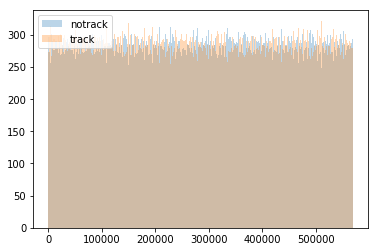

In [81]:
filter2 = filter.copy()
classes, class_counts = np.unique(targets[filtered_idx], return_counts=True)
min_class_size = np.min(class_counts)
for class_, class_count in zip(classes, class_counts):
    # Remove the last samples of the larger class
    class_idx = np.where(np.logical_and((targets == class_), filter))[0]
    np.random.shuffle(class_idx)
    filter2[class_idx[min_class_size : ]] = False
    
    
    
targets_filtered = targets[np.where(filter2)[0]]
idxs_track_filtered = np.where(targets_filtered == 1)[0]
idxs_non_track_filtered = np.where(targets_filtered == 0)[0]
_ = plt.hist(idxs_non_track_filtered, bins=1000, label='notrack', alpha=.3)
_ = plt.hist(idxs_track_filtered, bins=1000, label='track', alpha=.3)
plt.legend()
idxs_track_filtered.shape, idxs_non_track_filtered.shape

0 0.0 0.0
(672131,)
0 [ 747281  747283  747284 ... 1762363 1762364 1762365]
1 1.0 0.0
(284650,)
1 []


((284650,), (284650,))

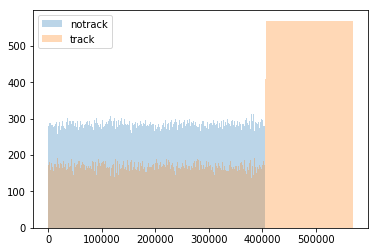

In [75]:
filter2 = filter.copy()
classes, class_counts = np.unique(targets[filtered_idx], return_counts=True)
min_class_size = np.min(class_counts)
for class_ in classes:
    # Remove the last samples of the larger class
    class_idx = np.where(np.logical_and((targets == class_), filter))[0]
    print(class_, targets[class_idx].mean(), targets[class_idx].std())
    print(class_idx.shape)
    print(class_, class_idx[min_class_size : ])
    filter2[class_idx[min_class_size : ]] = False
    
    
targets_filtered = targets[np.where(filter2)[0]]
idxs_track_filtered = np.where(targets_filtered == 1)[0]
idxs_non_track_filtered = np.where(targets_filtered == 0)[0]
_ = plt.hist(idxs_non_track_filtered, bins=1000, label='notrack', alpha=.3)
_ = plt.hist(idxs_track_filtered, bins=1000, label='track', alpha=.3)
plt.legend()
idxs_track_filtered.shape, idxs_non_track_filtered.shape

In [ ]:
idxs

In [2]:
%pwd

'/media/dominik/d/uni/uare/icecube/NuIntClassification'

In [22]:
targets = np.load('targets_train.hd5.npy')
targets.shape

(569300,)

In [23]:
idxs_track = np.where(targets == 1)[0]
idxs_non_track = np.where(targets == 0)[0]
idxs_track.shape, idxs_non_track.shape

((284650,), (284650,))

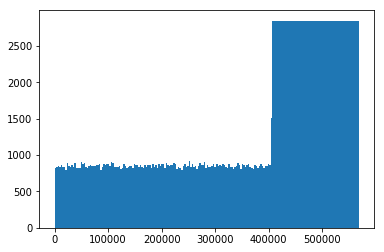

In [24]:
_ = plt.hist(idxs_track, bins=200)

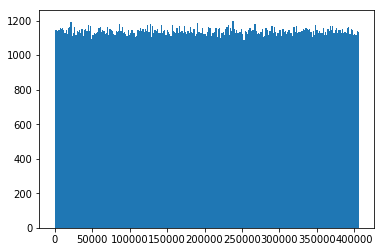

In [25]:
_ = plt.hist(idxs_non_track, bins=250)

In [3]:
with open('training/hd5-6181356400/config.json') as f:
    config = json.load(f)
data = util.dataset_from_config(config)

/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:355: RuntimeWarning: invalid value encountered in less
  idx_removed = np.where(np.logical_and((track_length < min_track_length), has_track_length))[0]
/media/dominik/d/uni/uare/icecube/NuIntClassification/dataset/hd5.py:361: RuntimeWarning: invalid value encountered in greater
  idx_removed = np.where(np.logical_and((cascade_energy > max_cascade_energy), has_track_length))


After Track Length filter 1333960 / 2202957 events remain.
After Cascade Energy filter 1167113 / 2202957 events remain.
Reduced dataset to 326328 samples per class (652656 / 2202957)
Created sha1 hash for features and data file c7186ad6f4095a7ceb2168696ef104bbe0381efa
Loaded feature memmap ./memmaps/hd5_features_c7186ad6f4095a7ceb2168696ef104bbe0381efa.
Loaded distances memmap ./memmaps/hd5_distances_c7186ad6f4095a7ceb2168696ef104bbe0381efa.


In [16]:
track_idx = np.where(data.targets == 1)[0]
non_track_idx = np.where(data.targets == 0)[0]
numu_nc_positive_idx = np.array([132626,  45518, 210986,  88710, 120602, 128937, 190098,  84665,
        58167])

In [9]:
def get_sample(idx):
    offset = data.file['Offset'][idx]['value']
    size = data.file['NumberVertices'][idx]['value']
    sample = {}
    for feature in ('ChargeFirstPulse', 'ChargeLastPulse', 'ChargeMaxPulse',
                  'TimeFirstPulse', 'TimeLastPulse', 'TimeMaxPulse', 'TimeVariance',
                  'VertexX', 'VertexY', 'VertexZ'):
        sample[feature] = np.array(data.file[feature][offset : offset + size]['item'])
    #pdgenc, interaction_type = file['PDGEncoding'][idx]['value'], file['InteractionType'][idx]['value']
    return pd.DataFrame(sample)
get_sample(1337)

,ChargeFirstPulse,ChargeLastPulse,ChargeMaxPulse,TimeFirstPulse,TimeLastPulse,TimeMaxPulse,TimeVariance,VertexX,VertexY,VertexZ
0,0.825,0.825,0.825,0.261147,0.261147,0.261147,0.261147,-1.646581,0.567251,2.516974
1,0.625,0.625,0.625,-0.262853,-0.262853,-0.262853,0.262853,-1.646581,0.567251,0.265234
2,0.875,0.875,0.875,0.172147,0.172147,0.172147,0.172147,0.491998,0.899219,1.751400
3,1.025,1.025,1.025,-0.109853,-0.109853,-0.109853,0.109853,0.491998,0.899219,0.550343
4,1.075,1.025,1.075,0.014147,0.350147,0.014147,0.244835,0.491998,0.899219,0.250239
5,1.375,1.375,1.375,-0.286853,-0.286853,-0.286853,0.286853,0.491998,0.899219,-0.350396
6,0.825,0.825,0.825,-0.164853,-0.164853,-0.164853,0.164853,0.491998,0.899219,-0.800659
7,0.975,0.975,0.975,0.006147,0.006147,0.006147,0.006147,2.614975,1.220698,-0.377600
8,1.025,1.325,1.325,0.680147,1.374147,1.374147,1.125362,-0.296967,-1.141883,-0.083709
9,0.675,0.675,0.675,-0.237853,-0.237853,-0.237853,0.237853,-0.296967,-1.141883,-0.384026


In [10]:
samples_numu_nc = np.where(np.logical_and((np.abs(data.file['PDGEncoding']['value']) == 14), 
                                 data.file['InteractionType']['value'] == 2))[0]
np.random.shuffle(samples_numu_nc)

In [11]:
samples_numu_cc = np.where(np.logical_and((np.abs(data.file['PDGEncoding']['value']) == 14), 
                                 data.file['InteractionType']['value'] == 1))[0]
np.random.shuffle(samples_numu_cc)

In [12]:
(data.targets[samples_numu_cc] == 1).all()

True

In [13]:
(data.targets[samples_numu_nc] == 0).all()

True

In [24]:
def plot_samples(idxs, attribute_to_plot='ChargeMaxPulse'):
    ncols = 3
    nrows = int(np.ceil(len(idxs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 15))
    for number, idx in enumerate(idxs):
        df = get_sample(idx)
        is_track = data.targets[idx] == 1
        ax = fig.add_subplot(nrows, ncols, number + 1, projection='3d')
        #print(graph[:, -3:])
        p = ax.scatter(df['VertexX'], df['VertexY'], zs=df['VertexZ'], s=18*df[attribute_to_plot],
                  c=df['TimeMaxPulse'], depthshade=False)
        fig.colorbar(p, label=f'Time of {attribute_to_plot}')

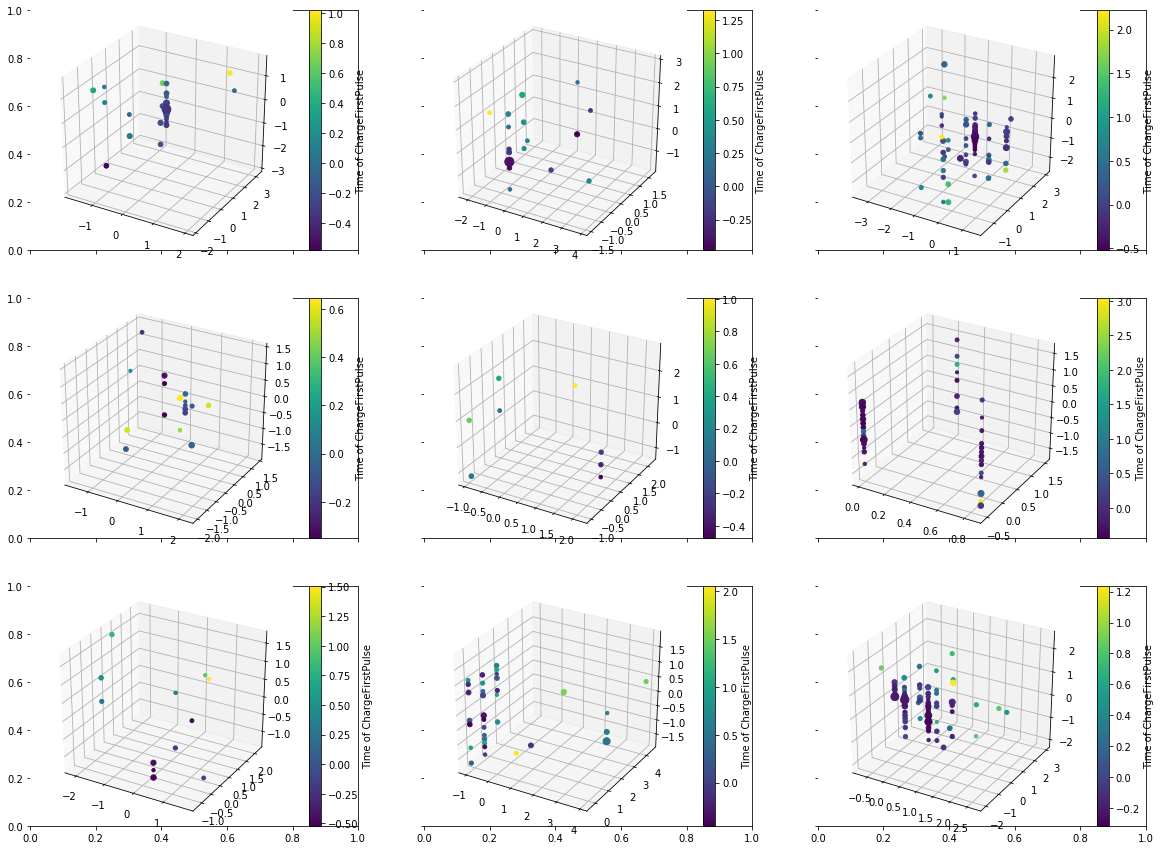

In [25]:

plot_samples(numu_nc_positive_idx, attribute_to_plot='ChargeFirstPulse')

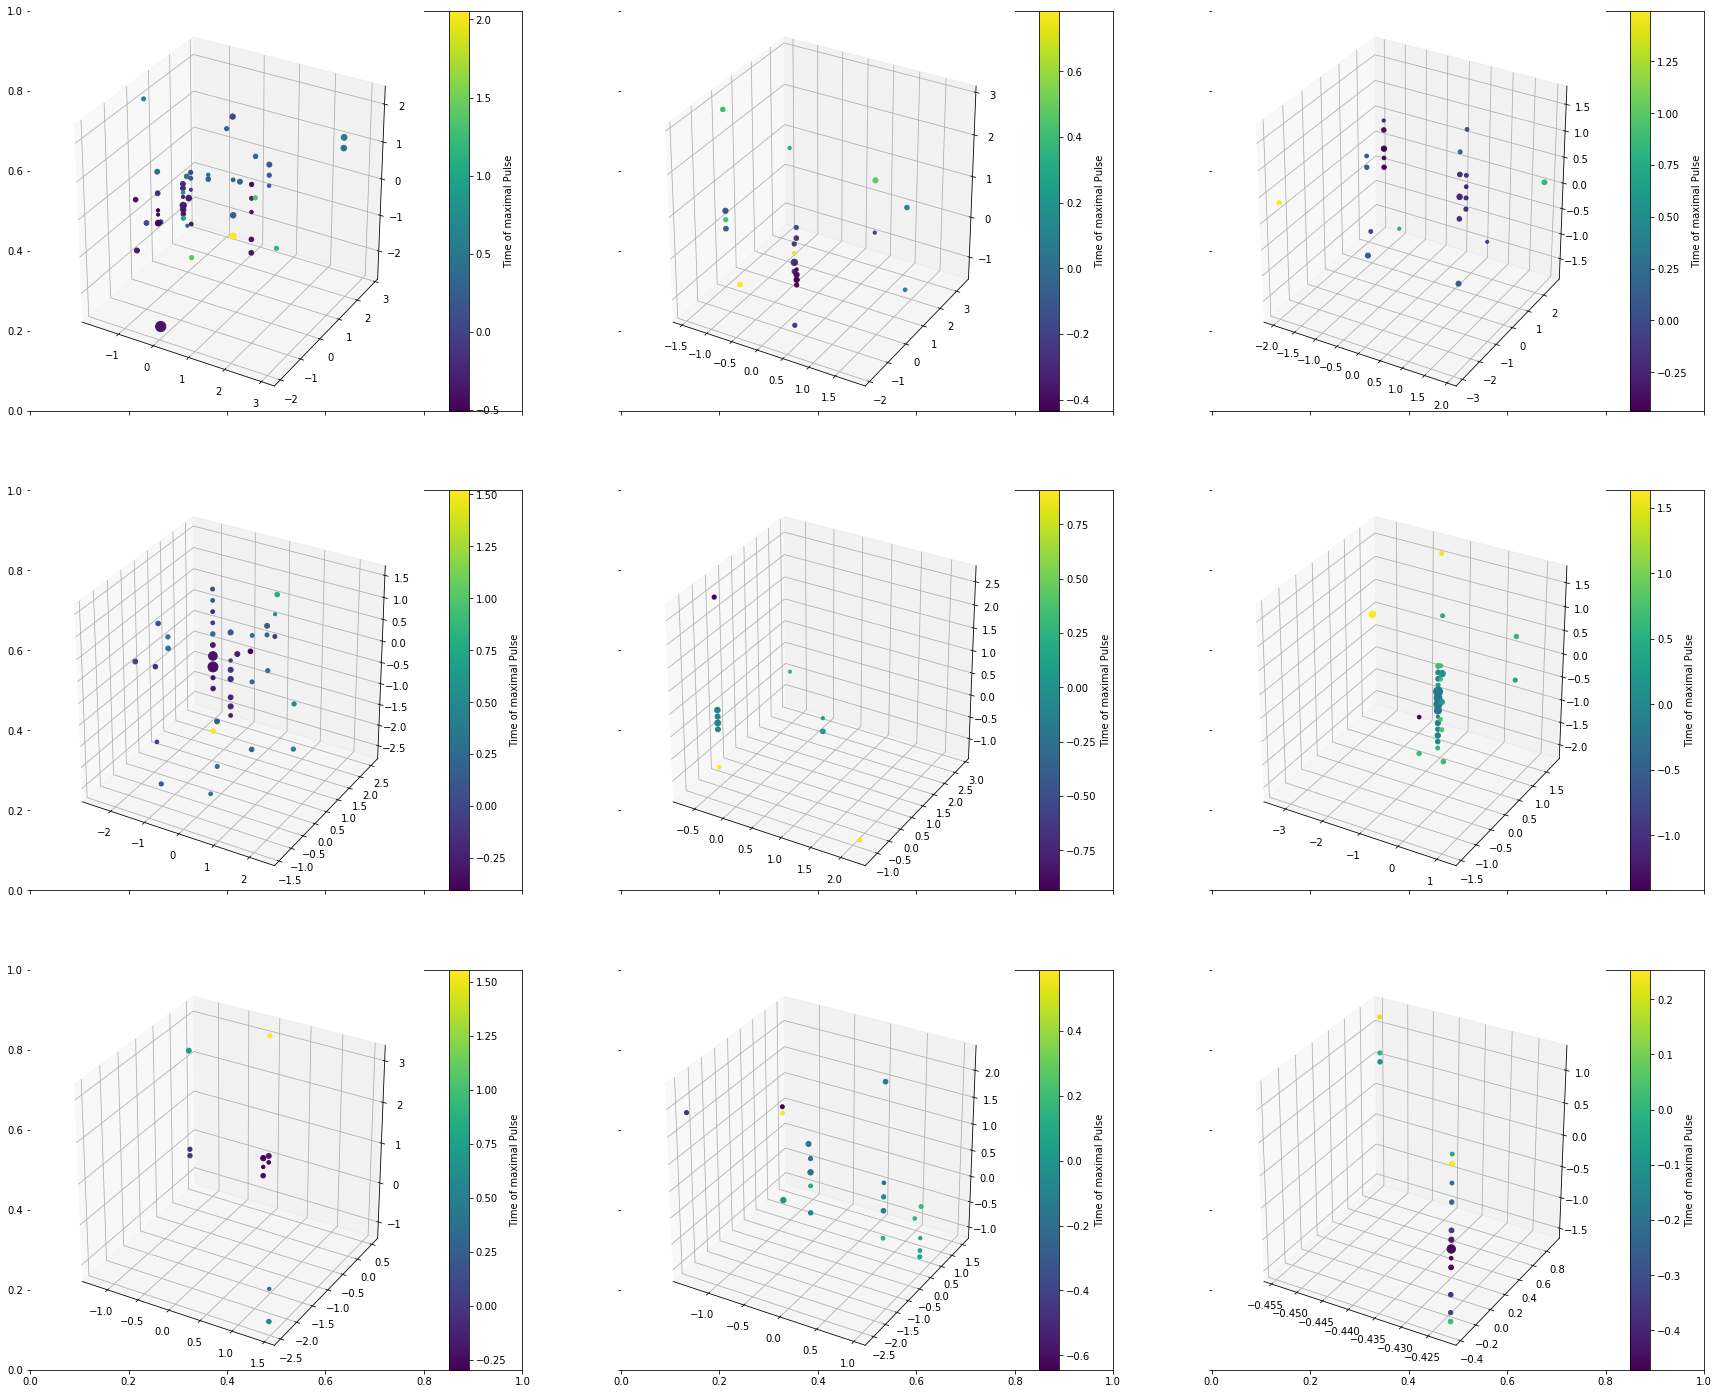

In [51]:

plot_samples(samples_numu_cc[100:109], attribute_to_plot='ChargeFirstPulse')


   ChargeFirstPulse  ChargeLastPulse  ChargeMaxPulse  TimeFirstPulse  \
0             0.525            0.525        0.525000        1.088133   
1             0.975            0.975        0.975000        0.175132   
2             0.925            0.925        0.925000        0.224132   
3             0.625            2.325        2.325000       -0.039868   
4            13.375            0.675       39.525002       -0.121868   

   TimeLastPulse  TimeMaxPulse  TimeVariance   VertexX   VertexY   VertexZ  
0       1.088133      1.088133      1.088133 -1.328511 -1.538754 -1.300750  
1       0.175132      0.175132      0.175132 -0.456646  0.282958  1.252494  
2       0.224132      0.224132      0.224132 -0.456646  0.282958  0.796213  
3      -0.012868     -0.012868      0.026580 -0.456646  0.282958  0.339664  
4      -0.049868     -0.115868      0.114974 -0.456646  0.282958 -0.116617  


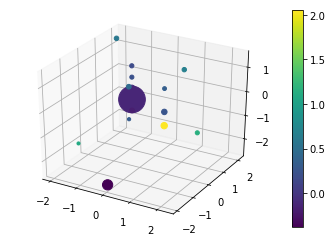

In [34]:
plot_sample(non_track_idx[138])

In [3]:
tmu = tables.open_file('data_dragon_3y_numu.hd5')
te = tables.open_file('data_dragon_3y_nue.hd5')
ttau = tables.open_file('data_dragon_3y_nutau.hd5')

In [5]:
tmu.root.RecoX

NoSuchNodeError: group ``/`` does not have a child named ``RecoX``